Импортируем необходимые библиотеки

In [1]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf

Загрузим данные

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Посмотрим на объемы загруженных данных

In [3]:
print('Training data size : ', x_train.shape)
print('Test data size: ', x_test.shape) 

Training data size :  (60000, 28, 28)
Test data size:  (10000, 28, 28)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

Выведем какое-нибудь изображение

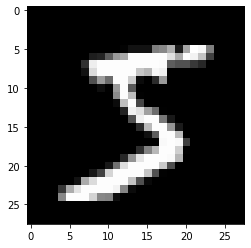

In [5]:
plt.imshow(x_train[0], cmap='gray')
plt.show()

Сформируем данные-строки для подачи на вход нейронной сети, нормируем данные

In [6]:
X_train = np.reshape(x_train, [-1, 28*28])
X_train = X_train.astype('float32') / 255
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Укажем, что лейблы — целые

In [7]:
y_train = y_train.astype('int64')
y_train

array([5, 0, 4, ..., 5, 6, 8])

То же самое проделаем с тестовыми данными

In [8]:
X_test = np.reshape(x_test, [-1, 28 * 28])
X_test = X_test.astype('float32') / 255
y_test = y_test.astype('int64')

In [9]:
batch_size = 100 # размер батча для обучения
num_input = 784  # количество входных нейронов (28 * 28)
num_hidden1 = 100 # количество нейронов первого скрытого слоя
num_hidden2 = 100 # количество нейронов второго скрытого слоя
num_hidden3 = 100 # количество нейронов третьего скрытого слоя
num_output = 10 # количество выходов (такое же, как количество классов)

Создадим архитектуру сети

In [10]:
def multi_layer_perceptron_mnist(x, weights, biases):
  hidden_layer1 = tf.add(tf.matmul(x, weights['w_h1']), biases['b_h1'])
  hidden_layer1 = tf.nn.relu(hidden_layer1)
  hidden_layer2 = tf.add(tf.matmul(hidden_layer1, weights['w_h2']), biases['b_h2'])
  hidden_layer2 = tf.nn.relu(hidden_layer2)
  hidden_drop = tf.nn.dropout(hidden_layer2, 0.1)
  hidden_layer3 = tf.add(tf.matmul(hidden_drop, weights['w_h3']), biases['b_h3'])
  hidden_layer3 = tf.nn.relu(hidden_layer3)

  out_layer = tf.add(tf.matmul(hidden_layer3, weights['w_out']), biases['b_out'])
 
  return out_layer

In [11]:
weights = {
 'w_h1' : tf.Variable(tf.random.normal([num_input, num_hidden1])),
 'w_h2' : tf.Variable(tf.random.normal([num_hidden1, num_hidden2])),
 'w_h3' : tf.Variable(tf.random.normal([num_hidden2, num_hidden3])),
 'w_out': tf.Variable(tf.random.normal([num_hidden3, num_output]))
}
biases = {
 'b_h1' : tf.Variable(tf.random.normal([num_hidden1])),
 'b_h2' : tf.Variable(tf.random.normal([num_hidden2])),
 'b_h3' : tf.Variable(tf.random.normal([num_hidden3])),
 'b_out': tf.Variable(tf.random.normal([num_output]))
} 

In [12]:
learning_rate = 0.01
num_iter = 600
batch_size = 100
display_step = 10 

Зададим начальный батч

In [13]:
indices = tf.constant(np.random.choice(X_train.shape[0], batch_size), shape = (batch_size, 1))
X_batch, y_batch = tf.gather_nd(X_train, indices), tf.gather_nd(y_train, indices)
X_batch.shape

TensorShape([100, 784])

Определим модель: саму модуль и функцию потерь

In [14]:
@tf.function
def model(X_batch):
  return multi_layer_perceptron_mnist(X_batch, weights, biases)

In [15]:
@tf.function
def loss():
  return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = model(X_batch), labels = y_batch))

Зададим оптимизатор (пока что наугад)

In [16]:
optimizer = tf.optimizers.Adam(learning_rate)

Поехали обучаться

In [17]:
for i in range(num_iter):
  indices = tf.constant(np.random.choice(X_train.shape[0], batch_size), shape = (batch_size, 1))
  X_batch, y_batch = tf.gather_nd(X_train, indices), tf.gather_nd(y_train, indices)
  optimizer.minimize(loss, [weights, biases])

Теперь посмотрим на софтмакс

In [18]:
results = tf.nn.softmax(model(X_test))

In [19]:
results[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>

In [20]:
image = np.reshape(X_test[0], [-1, 28])

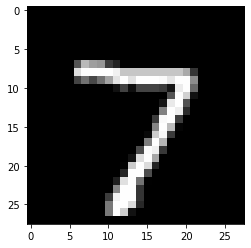

In [21]:
plt.imshow(image, cmap='gray')
plt.show()

Давайте поймем, как там с Accuracy

In [22]:
y_test

array([7, 2, 1, ..., 4, 5, 6])

In [23]:
results.shape

TensorShape([10000, 10])

In [24]:
y_test = tf.constant(y_test)
y_test.shape

TensorShape([10000])

In [25]:
correct_predictions = tf.equal(tf.argmax(results, 1), y_test)
correct_predictions

<tf.Tensor: shape=(10000,), dtype=bool, numpy=array([ True, False,  True, ...,  True,  True,  True])>

In [26]:
Accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
Accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.5377>